## Deblending

Deblending attempts to separate detections with multiple peaks into separate objects.  We keep all of the original sources in the `SourceCatalog` (called `parent`s) when we deblend, but for each `parent` source that contains more than one peak, we create a new record (called a `child`) for each of those peaks.  The `Footprint`s attached to the `child` objects are instances of a subclass called `HeavyFootprint`, which include new deblended pixel values as well as the region description.  These can be used by calling `insert` to replace an `Image`'s pixels with the `HeavyFootprint`'s pixels.


In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lsst.afw.display as afw_display
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["figure.dpi"] = 120

In [2]:
from lsst.daf.persistence import Butler

datadir = '/home/YOUR_USER_NAME/ci_hsc_small/rerun/YOUR_RERUN_NAME'
butler = Butler(datadir)

We're going to get the fully calibrated exposure this time (a "calexp"), instead of the "PostISRCCD" we used for the intro to processCcd. ProcessCcd will have already performed measurement and deblending, but we will repeat those steps so we can investigate how they work.

In [3]:
exposure = butler.get("calexp", visit=903334, ccd=16)

In [5]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.afw.table import SourceTable, SourceCatalog

Remember that we need to initialize all tasks that we plan to run, so that they set up the right catalog schema.

In [6]:
from lsst.meas.deblender import SourceDeblendTask

schema = SourceTable.makeMinimalSchema()
detectTask = SourceDetectionTask(schema=schema)
deblendTask = SourceDeblendTask(schema=schema)

In [6]:
table = SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)

In [7]:
catalog = detectResult.sources
deblendTask.run(exposure, catalog)

Now that we have a catalog of deblended sources, we can pick out some interesting ones and plot them.

In [9]:
# Find some blended sources inside the subimage:
blendParents = []
bbox = exposure.getBBox()
for record in catalog:
    if record.get("deblend_nChild") > 0 and bbox.contains(record.getFootprint().getBBox()):
        blendParents.append(record)
# Sort by peak brightness so we can look at something with decent S/N
blendParents.sort(key=lambda r: -r.getFootprint().getPeaks()[0].getPeakValue())

In [10]:
from lsst.afw.image import Image

To inspect some deblender outputs, we'll start by finding some parent objects that were deblended into multiple children, by looking at the `deblend_nChild` field (which was added to the `Schema` when we constructed the `SourceDeblendTask`, and populated when we called `run`).

In [31]:
# Change this number to look at a different blend family.
blend_id = 0

In [28]:
blendParentImage = Image(exposure.image, bbox=blendParents[blend_id].getFootprint().getBBox(),
                         deep=True, dtype=np.float32)

Now we'll insert the deblended child pixels into blank images of the same size:

In [29]:
blendChildImages = []
for blendChild in catalog.getChildren(blendParents[blend_id].getId()):
    image = Image(blendParentImage.getBBox(), dtype=np.float32)
    blendChild.getFootprint().insert(image)
    blendChildImages.append(image)

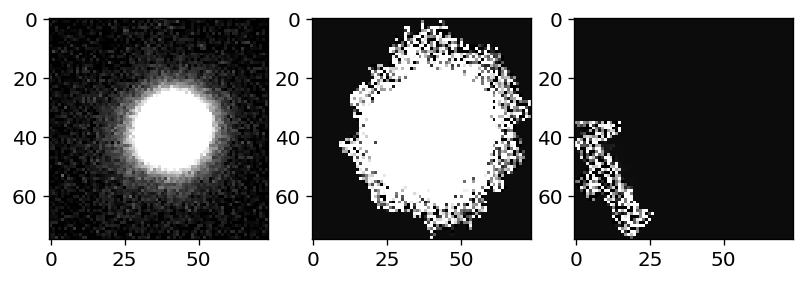

In [30]:
nSubPlots = len(blendChildImages) + 1
nCols = 3
nRows = nSubPlots//nCols + 1
matplotlib.pyplot.subplot(nRows, nCols, 1)
#display(blendParentImage, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)
plt.imshow(blendParentImage.array, vmin=-0.5, vmax=100, cmap='gray')

for n, image in enumerate(blendChildImages):
    matplotlib.pyplot.subplot(nRows, nCols, n + 2)
    plt.imshow(image.array, vmin=-0.5, vmax=10, cmap='gray')
    #display(image, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)

## Measurement

`SingleFrameMeasurementTask` is typically responsible for adding most fields to a `SourceCatalog`.  It runs a series of plugins that make different measurements (you can configure them with the `.plugins` dictionary-like field on its config object, and control which are run with `.names`).  If the deblender has been run first, it will measure child objects using their deblended pixels.



In [33]:
from lsst.meas.base import SingleFrameMeasurementTask

In [34]:
measureConfig = SingleFrameMeasurementTask.ConfigClass()

In [35]:
# What measurements are configured to run
print(measureConfig.plugins.names)

['base_GaussianFlux', 'base_NaiveCentroid', 'base_SdssCentroid', 'base_SkyCoord', 'base_PixelFlags', 'base_Variance', 'base_SdssShape', 'base_PsfFlux', 'base_LocalBackground', 'base_Blendedness', 'base_CircularApertureFlux']


In [36]:
# Import an extension module that adds a new measurement
import lsst.meas.extensions.photometryKron

In [37]:
# What measurements *could* be configured to run
print(list(measureConfig.plugins.keys()))

['base_PsfFlux', 'base_PeakLikelihoodFlux', 'base_GaussianFlux', 'base_NaiveCentroid', 'base_SdssCentroid', 'base_PixelFlags', 'base_SdssShape', 'base_ScaledApertureFlux', 'base_CircularApertureFlux', 'base_Blendedness', 'base_LocalBackground', 'base_FPPosition', 'base_Jacobian', 'base_Variance', 'base_InputCount', 'base_PeakCentroid', 'base_SkyCoord', 'subaru_FilterFraction', 'ext_photometryKron_KronFlux']


In [38]:
# Configure the new measurement to run
measureConfig.plugins.names.add("ext_photometryKron_KronFlux")

In [39]:

schema = SourceTable.makeMinimalSchema()
detectTask = SourceDetectionTask(schema=schema)
deblendTask = SourceDeblendTask(schema=schema)
measureTask = SingleFrameMeasurementTask(schema=schema, config=measureConfig)

In [40]:
table = SourceTable.make(schema)

detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
deblendTask.run(exposure, catalog)
measureTask.run(catalog, exposure)

We'll show some of the results of measurement by overlaying the measured ellipses on the image.

The shapes and centroids we use here (by calling `record.getX()`, `record.getY()`, `record.getShape()`) are aliases  (called "slots") to fields with longer names that are our recommended measurements for these quantities.  You can see the set of aliases by printing the schema (see next section).

In [41]:
from lsst.afw.geom.ellipses import Axes

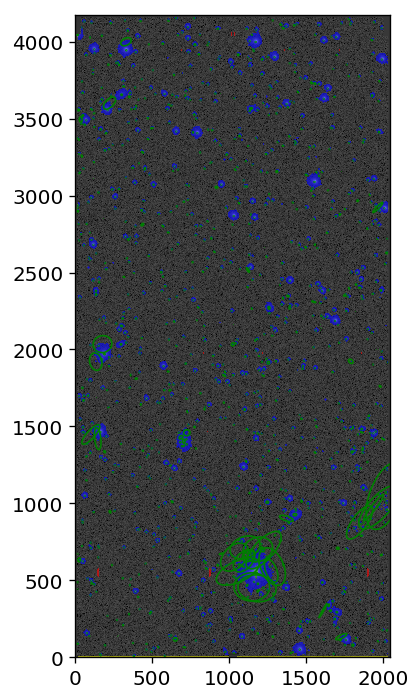

In [44]:
#display(sub.image, mask=sub.mask, colors={"DETECTED": "blue"}, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)

display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("asinh", "zscale")
display1.setMaskTransparency(40)
display1.mtv(exposure) #[700:1400,1800:2400])

for record in catalog:
    if record.get("deblend_nChild") != 0:
        continue
    axes = Axes(record.getShape())   # convert to A, B, THETA parameterization
    axes.scale(2.0)  # matplotlib uses diameters, not radii
    patch = matplotlib.patches.Ellipse((record.getX(), record.getY()),
                                       axes.getA(), axes.getB(), axes.getTheta() * 180.0 / np.pi,
                                      fill=False, edgecolor="green")
    matplotlib.pyplot.gca().add_patch(patch)


## Working With Catalogs

Print the schema:

In [ ]:
print(catalog.getSchema())

Get arrays of columns (requires the catalog to be continguous in memory, which we can guarantee with a deep copy):

In [46]:
catalog = catalog.copy(deep=True)

In [48]:
psfFlux = catalog["base_PsfFlux_instFlux"]

Note that boolean values are stored in `Flag` columns, which are packed into bits.  Unlike other column types, when you get an array of a `Flag` column, you get a copy, not a view.

Use `Key` objects instead of strings to do fast repeated access to fields when iterating over records:

In [49]:
key = catalog.getSchema().find("deblend_nChild").key
deblended = [record for record in catalog if record.get(key) == 0]

You can also get `dict` version of a subset of a `Schema`, a `Catalog`, or a `Record` by calling either `extract` methods with a glob:

In [ ]:
catalog[0].extract("base_PsfFlux_*")  # or regex='...'

For `Record`s, the dict values are just the values of the fields, and for `Catalogs`, they're `numpy.ndarray` columns.  For `Schema`s they're `SchemaItem`s, which behave liked a named tuple containing a `Key` and a `Field`, which contains more descriptive information.

Get an Astropy view of the catalog (from which you can make a Pandas view):

In [51]:
table = catalog.asAstropy()